In [1]:
%%capture capt
!pip install scikit-learn==1.1.2
!pip install -U scikit-survival
from tqdm import tqdm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest

set_config(display="text")  # displays text representation of estimators

## Notre base

In [2]:
profil_patient=pd.read_csv("../data/profil_patient_cluster.csv")
profil_patient['CHOC']=profil_patient['CHOC'].astype(int)
profil_patient

,CODE_PATIENT,date_h0,y_nais,BEN_RES_DPT,BEN_SEX_COD,dte_deces,Mort,Nb_survie,Nb_hospit,CHOC,...,cluster12,cluster13,cluster14,cluster15,cluster16,cluster17,cluster18,cluster19,cluster20,p_soins
0,P0,2011-11-22,1949,11,1,NaN,False,2596,9,0,...,0,0,0,0,0,0,0,0,0,"05K051,05M042,05M16T,05M09T,05M092,05C191,05M2..."
1,P6,2013-12-05,1929,14,2,2015-03,True,456,8,0,...,0,0,0,0,0,1,0,0,0,"02C05J,02C05J,05M093,04M132,05C222,23M103,04M0..."
2,P8,2015-07-02,1967,54,2,2015-08,True,41,3,1,...,0,0,0,0,0,0,1,0,0,"11M041,06C194"
3,P13,2011-05-19,1959,974,1,NaN,False,2783,2,0,...,0,0,0,0,0,0,0,0,0,"05M04T,05K051"
4,P16,2010-03-18,1947,76,1,NaN,False,3210,9,0,...,0,0,0,0,0,0,1,0,0,"08C11V,23M15Z,05K102,05M08T,05K102,05C191,23M1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10046,P24302,2014-02-08,1920,29,1,2014-12,True,318,8,0,...,0,0,0,1,0,0,0,0,0,"04M05V,23M20T,05M082,06M033,09M031,05M093,10M1..."
10047,P24303,2012-02-09,1927,61,1,2017-05,True,1924,12,0,...,0,1,0,0,0,0,0,0,0,"05M094,05M09T,05K052,23M101,09M053,05C143,23M1..."
10048,P24304,2010-07-27,1924,999,1,2010-08,True,5,1,0,...,0,0,0,0,0,0,1,0,0,05M082
10049,P24308,2011-11-25,1925,13,2,2013-03,True,484,7,0,...,0,0,0,0,1,0,0,0,0,"05M091,04M173,04M171,04C042,23M061,07M023,04M174"


In [4]:
Liste_label=['y_nais','BEN_SEX_COD','Nb_hospit','CHOC','Nb_jours_sej']
for i in range(1,21):
    Liste_label.append('cluster' + str(i))
data=profil_patient[Liste_label]
Label= profil_patient[['Mort','Nb_survie']].to_records(index=False)
Label

rec.array([(False, 2596), ( True,  456), ( True,   41), ...,
           ( True,    5), ( True,  484), (False, 2935)],
          dtype=[('Mort', '?'), ('Nb_survie', '<i8')])

In [6]:
data.head()

,y_nais,BEN_SEX_COD,Nb_hospit,CHOC,Nb_jours_sej,cluster1,cluster2,cluster3,cluster4,cluster5,...,cluster11,cluster12,cluster13,cluster14,cluster15,cluster16,cluster17,cluster18,cluster19,cluster20
0,1949,1,9,0,23,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1929,2,8,0,51,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1967,2,3,1,43,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1959,1,2,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1947,1,9,0,28,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [7]:
random_state = 20

X_train, X_test, y_train, y_test = train_test_split(data, Label, test_size=0.25, random_state=random_state)

In [8]:
rsf = RandomSurvivalForest(n_estimators=10,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           n_jobs=-1,
                           random_state=random_state,
                           verbose=0)
rsf.fit(X_train, y_train)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10, n_estimators=10,
                     n_jobs=-1, random_state=20)

In [9]:
rsf.score(X_test, y_test)

0.6770998096666498

In [10]:
X_test_sorted = X_test.sort_values(by=['y_nais'])
X_test_sel = pd.concat((X_test_sorted.head(3), X_test_sorted.tail(3)))

X_test_sel

,y_nais,BEN_SEX_COD,Nb_hospit,CHOC,Nb_jours_sej,cluster1,cluster2,cluster3,cluster4,cluster5,...,cluster11,cluster12,cluster13,cluster14,cluster15,cluster16,cluster17,cluster18,cluster19,cluster20
5471,1909,2,5,0,35,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1275,1910,2,2,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4626,1910,2,6,0,62,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9775,1990,1,3,0,48,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
472,1991,1,19,0,67,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6602,1994,2,62,1,135,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
pd.Series(rsf.predict(X_test_sel))

0    2754.910410
1    3131.925104
2    2043.682374
3    1160.871091
4     496.648648
5     929.438986
dtype: float64

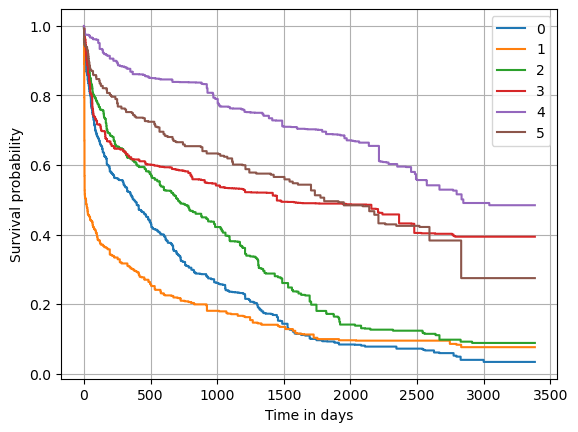

In [12]:
surv = rsf.predict_survival_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.event_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

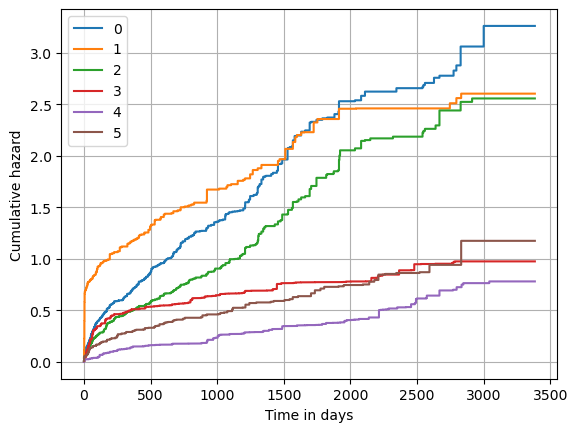

In [13]:
surv = rsf.predict_cumulative_hazard_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.event_times_, s, where="post", label=str(i))
plt.ylabel("Cumulative hazard")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

In [14]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rsf, X_test, y_test, n_repeats=15, random_state=random_state)

In [15]:
pd.DataFrame(
    {k: result[k] for k in ("importances_mean", "importances_std",)},
    index=X_test.columns
).sort_values(by="importances_mean", ascending=False)

,importances_mean,importances_std
y_nais,0.100121,0.006677
Nb_hospit,0.056541,0.003494
Nb_jours_sej,0.036000,0.002567
cluster19,0.007927,0.000923
BEN_SEX_COD,0.006646,0.001083
CHOC,0.004827,0.000676
cluster18,0.001644,0.000828
cluster3,0.001253,0.000271
cluster15,0.000942,0.000383
cluster7,0.000804,0.000459


## Essai 2

In [16]:
profil_patient=pd.read_csv("../data/profil_patient_cluster.csv")
profil_patient['CHOC']=profil_patient['CHOC'].astype(int)
Liste_label=['y_nais','BEN_SEX_COD','Nb_hospit','CHOC','Nb_jours_sej']
for i in range(1,21):
    Liste_label.append('cluster' + str(i))
data=profil_patient[Liste_label]
Label= profil_patient[['Mort','Nb_survie']].to_records(index=False)
Label

rec.array([(False, 2596), ( True,  456), ( True,   41), ...,
           ( True,    5), ( True,  484), (False, 2935)],
          dtype=[('Mort', '?'), ('Nb_survie', '<i8')])

In [17]:
random_state = 20

X_train, X_test, y_train, y_test = train_test_split(data, Label, test_size=0.25, random_state=random_state)

In [18]:
rsf = RandomSurvivalForest(n_estimators=10,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           n_jobs=-1,
                           random_state=random_state,
                           verbose=0)
rsf.fit(X_train, y_train)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10, n_estimators=10,
                     n_jobs=-1, random_state=20)

In [19]:
rsf.score(X_test, y_test)

0.6770998096666498

In [20]:
X_test_sorted = X_test.sort_values(by=['y_nais'])
X_test_sel = pd.concat((X_test_sorted.head(5), X_test_sorted.tail(5)))

X_test_sel

,y_nais,BEN_SEX_COD,Nb_hospit,CHOC,Nb_jours_sej,cluster1,cluster2,cluster3,cluster4,cluster5,...,cluster11,cluster12,cluster13,cluster14,cluster15,cluster16,cluster17,cluster18,cluster19,cluster20
5471,1909,2,5,0,35,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1275,1910,2,2,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4626,1910,2,6,0,62,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6656,1911,2,3,0,21,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7931,1911,2,1,0,3,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2839,1989,1,11,0,31,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4785,1990,2,69,0,534,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
9775,1990,1,3,0,48,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
472,1991,1,19,0,67,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6602,1994,2,62,1,135,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
pd.Series(rsf.predict(X_test_sel))

0    2754.910410
1    3131.925104
2    2043.682374
3    3411.107750
4    3189.366580
5     379.463675
6     517.850596
7    1160.871091
8     496.648648
9     929.438986
dtype: float64

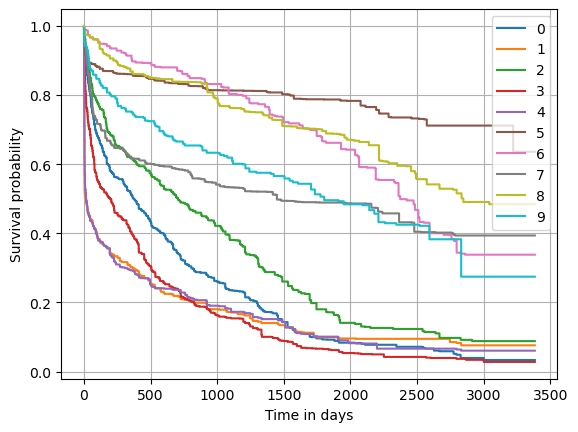

In [22]:
surv = rsf.predict_survival_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.event_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

In [23]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rsf, X_test, y_test, n_repeats=10, random_state=random_state)

In [24]:
pd.DataFrame(
    {k: result[k] for k in ("importances_mean", "importances_std",)},
    index=X_test.columns
).sort_values(by="importances_mean", ascending=False)

,importances_mean,importances_std
y_nais,0.101501,0.005839
Nb_hospit,0.056006,0.003741
Nb_jours_sej,0.035959,0.001665
cluster19,0.007964,0.000979
BEN_SEX_COD,0.007052,0.000827
CHOC,0.004903,0.000691
cluster18,0.001853,0.000825
cluster3,0.001234,0.000261
cluster15,0.000875,0.000374
cluster7,0.000655,0.000468


In [49]:
rsf.decision_path(X_train)

(<7538x4142 sparse matrix of type '<class 'numpy.int64'>'
 	with 784406 stored elements in Compressed Sparse Row format>,
 array([   0,  413,  784, 1241, 1662, 2061, 2508, 2977, 3342, 3781, 4142]))

In [25]:
from sksurv.compare import compare_survival
print("Compares the pooled hazard rate with each group-specific hazard rate.")
print("The alternative hypothesis is that the hazard rate of at least one group differs from the others at some time.")
print("Valeur de la statistique | p-valeur")
compare_survival(Label[0:20], X_test[0:20], return_stats=False)

Compares the pooled hazard rate with each group-specific hazard rate.
The alternative hypothesis is that the hazard rate of at least one group differs from the others at some time.
Valeur de la statistique | p-valeur


(200.27193268454198, 8.025439605924745e-21)

## Recherche du bon nombre d'estimateurs pour les Survival Random Forest 

In [26]:
profil_patient=pd.read_csv("../data/profil_patient_cluster.csv")
profil_patient['CHOC']=profil_patient['CHOC'].astype(int)
Liste_label=['y_nais','BEN_SEX_COD','Nb_hospit','CHOC','Nb_jours_sej']
for i in range(1,21):
    Liste_label.append('cluster' + str(i))
data=profil_patient[Liste_label]
Label= profil_patient[['Mort','Nb_survie']].to_records(index=False)
Label

rec.array([(False, 2596), ( True,  456), ( True,   41), ...,
           ( True,    5), ( True,  484), (False, 2935)],
          dtype=[('Mort', '?'), ('Nb_survie', '<i8')])

In [27]:
random_state = 20

X_train, X_test, y_train, y_test = train_test_split(data, Label, test_size=0.25, random_state=random_state)

0.647912419608017
0.6627105933696668
0.6704058315794061
0.6710041455550437
0.6711271897164386
0.6731980887015028
0.6731362848402831
0.6751651046006869
0.6763752580170316
0.6770998096666498
0.6771185950348018
0.6766718789801499
0.6768935463243422
0.6783524180150178
0.6790760303962285
0.6787414629894434
0.6785267462314672
0.6790848595192599
0.6790651348827004


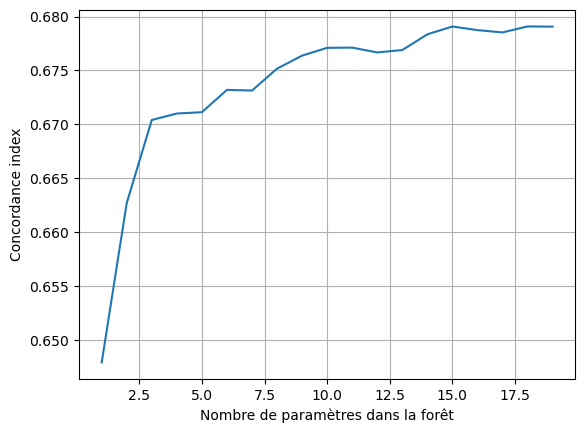

In [28]:
Liste_score = []
Liste_nb_estimators= []
rsf = RandomSurvivalForest(min_samples_split=10,
                           min_samples_leaf=15,
                           n_jobs=-1,
                           random_state=random_state,
                           verbose=0)
for i in range(1, 20):
    n_estimators = i * 1
    rsf.set_params(n_estimators=n_estimators)
    rsf.fit(X_train, y_train)
    Liste_score.append(rsf.score(X_test, y_test))
    Liste_nb_estimators.append(n_estimators)
    print(rsf.score(X_test, y_test))
    

plt.plot(Liste_nb_estimators, Liste_score)
plt.xlabel("Nombre de paramètres dans la forêt")
plt.ylabel("Concordance index")
plt.grid(True)

## Gradient boosting

In [29]:
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
profil_patient=pd.read_csv("../data/profil_patient_cluster.csv")
profil_patient['CHOC']=profil_patient['CHOC'].astype(int)
Liste_label=['y_nais','BEN_SEX_COD','Nb_hospit','CHOC','Nb_jours_sej']
for i in range(1,21):
    Liste_label.append('cluster' + str(i))
data=profil_patient[Liste_label]
Label= profil_patient[['Mort','Nb_survie']].to_records(index=False)
Label

rec.array([(False, 2596), ( True,  456), ( True,   41), ...,
           ( True,    5), ( True,  484), (False, 2935)],
          dtype=[('Mort', '?'), ('Nb_survie', '<i8')])

In [30]:
random_state = 20
X_train, X_test, y_train, y_test = train_test_split(data, Label, test_size=0.25, random_state=random_state)

In [31]:
est_cph_tree = GradientBoostingSurvivalAnalysis(n_estimators=10, learning_rate=1.0, max_depth=1, random_state=0, verbose=1)
est_cph_tree.fit(X_train, y_train)
cindex = est_cph_tree.score(X_test, y_test)
print(round(cindex, 3))

      Iter       Train Loss   Remaining Time 
         1       41144.3828           10.02s
         2       41048.9260            8.88s
         3       40973.7307            7.71s
         4       40924.5716            6.58s
         5       40895.6392            5.52s
         6       40867.9464            4.38s
         7       40840.2105            3.28s
         8       40815.7319            2.19s
         9       40786.0066            1.10s
        10       40763.6747            0.00s
0.664


In [ ]:
scores_cph_tree = {}
est_cph_tree = GradientBoostingSurvivalAnalysis(learning_rate=1.0, max_depth=1, random_state=0, verbose=1)
for i in range(1, 40,2):
    n_estimators = i 
    est_cph_tree.set_params(n_estimators=n_estimators)
    est_cph_tree.fit(X_train, y_train)
    scores_cph_tree[n_estimators] = est_cph_tree.score(X_test, y_test)

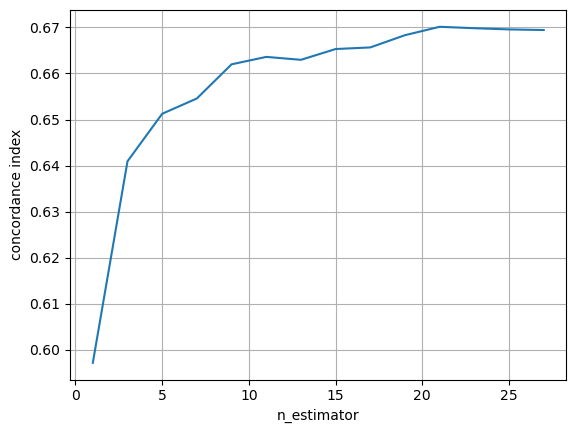

In [33]:
x, y = zip(*scores_cph_tree.items())
plt.plot(x, y)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.grid(True)

In [35]:
scores_cph_ls = {}

est_cph_ls = ComponentwiseGradientBoostingSurvivalAnalysis(learning_rate=1.0, random_state=0,verbose=1)
for i in range(1, 15,2):
    n_estimators = i 
    est_cph_ls.set_params(n_estimators=n_estimators)
    est_cph_ls.fit(X_train, y_train)
    scores_cph_ls[n_estimators] = est_cph_ls.score(X_test, y_test)

      Iter       Train Loss   Remaining Time 
         1       41429.9447            0.00s
      Iter       Train Loss   Remaining Time 
         1       41429.9447            2.27s
         2       41399.3352            1.15s
         3       41375.7698            0.00s
      Iter       Train Loss   Remaining Time 
         1       41429.9447            4.11s
         2       41399.3352            3.15s
         3       41375.7698            2.12s
         4       41362.9708            1.06s
         5       41350.4741            0.00s
      Iter       Train Loss   Remaining Time 
         1       41429.9447            6.26s
         2       41399.3352            5.32s
         3       41375.7698            4.35s
         4       41362.9708            3.27s
         5       41350.4741            2.17s
         6       41335.0989            1.08s
         7       41324.1149            0.00s
      Iter       Train Loss   Remaining Time 
         1       41429.9447            8.48s
     

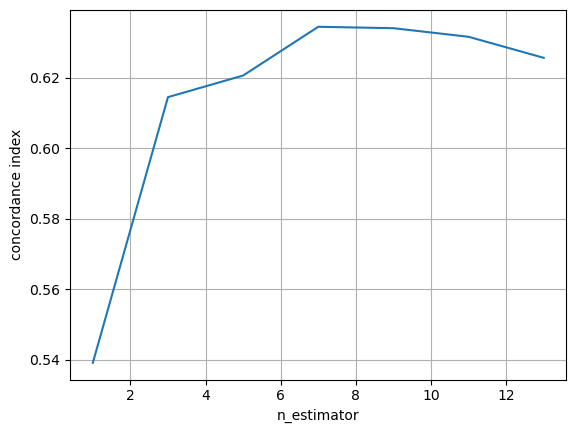

In [36]:
x, y = zip(*scores_cph_ls.items())
plt.plot(x, y)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.grid(True)

In [37]:
coef = pd.Series(est_cph_ls.coef_, ["Intercept"] + data.columns.tolist())

print("Number of non-zero coefficients:", (coef != 0).sum())
coef_nz = coef[coef != 0]
coef_order = coef_nz.abs().sort_values(ascending=False).index
coef_nz.loc[coef_order]

Number of non-zero coefficients: 6


cluster7       -0.355055
cluster19      -0.251682
CHOC            0.229819
cluster1        0.147902
Nb_hospit      -0.018420
Nb_jours_sej    0.001996
dtype: float64

In [38]:
profil_patient=profil_patient.dropna()
data=profil_patient[['y_nais','BEN_SEX_COD','Nb_hospit','CHOC','Nb_jours_sej']]
Label= profil_patient[['Mort','Nb_survie']].to_records(index=False)

data=data.dropna()

random_state = 20
X_train, X_test, y_train, y_test = train_test_split(data, Label, test_size=0.25, random_state=random_state)
est_aft_ls = ComponentwiseGradientBoostingSurvivalAnalysis(loss="ipcwls", n_estimators=300, learning_rate=1.0, random_state=0).fit(X_train, y_train)

cindex = est_aft_ls.score(X_test, y_test)
print(round(cindex, 3))

/opt/mamba/lib/python3.10/site-packages/sksurv/ensemble/boosting.py:308: RuntimeWarning: divide by zero encountered in log
  time = np.log(time)
/opt/mamba/lib/python3.10/site-packages/sksurv/ensemble/boosting.py:74: RuntimeWarning: invalid value encountered in subtract
  error[component] = squared_norm(residuals - l_pred)


ValueError: All-NaN slice encountered

In [ ]:
n_estimators = [i for i in range(1, 20,2)]

estimators = {
    "no regularization": GradientBoostingSurvivalAnalysis(
        learning_rate=1.0, max_depth=1, random_state=0,verbose=3),
    "learning rate": GradientBoostingSurvivalAnalysis(
        learning_rate=0.1, max_depth=1, random_state=0,verbose=3),
    "dropout": GradientBoostingSurvivalAnalysis(
        learning_rate=1.0, dropout_rate=0.1, max_depth=1, random_state=0,verbose=3),
    "subsample": GradientBoostingSurvivalAnalysis(
        learning_rate=1.0, subsample=0.5, max_depth=1, random_state=0,verbose=3),
}

scores_reg = {k: [] for k in estimators.keys()}
for n in n_estimators:
    for name, est in estimators.items():
        est.set_params(n_estimators=n)
        est.fit(X_train, y_train)
        cindex = est.score(X_test, y_test)
        scores_reg[name].append(cindex)

scores_reg = pd.DataFrame(scores_reg, index=n_estimators)

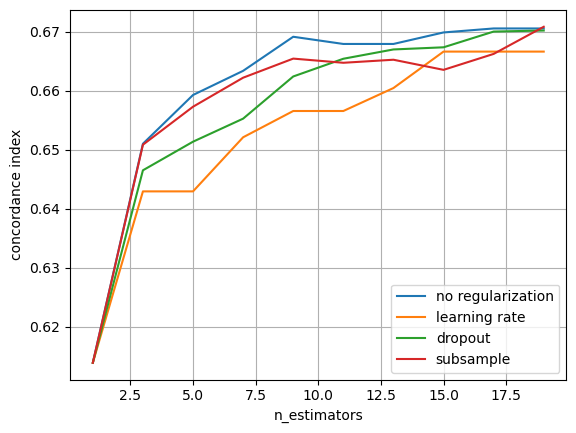

In [40]:
ax = scores_reg.plot(xlabel="n_estimators", ylabel="concordance index")
ax.grid(True)

In [41]:
class EarlyStoppingMonitor:

    def __init__(self, window_size, max_iter_without_improvement):
        self.window_size = window_size
        self.max_iter_without_improvement = max_iter_without_improvement
        self._best_step = -1

    def __call__(self, iteration, estimator, args):
        # continue training for first self.window_size iterations
        if iteration < self.window_size:
            return False

        # compute average improvement in last self.window_size iterations.
        # oob_improvement_ is the different in negative log partial likelihood
        # between the previous and current iteration.
        start = iteration - self.window_size + 1
        end = iteration + 1
        improvement = np.mean(estimator.oob_improvement_[start:end])

        if improvement > 1e-6:
            self._best_step = iteration
            return False  # continue fitting

        # stop fitting if there was no improvement
        # in last max_iter_without_improvement iterations
        diff = iteration - self._best_step
        return diff >= self.max_iter_without_improvement


est_early_stopping = GradientBoostingSurvivalAnalysis(
    n_estimators=50, learning_rate=1, subsample=0.5,
    max_depth=1, random_state=0,verbose=1)

monitor = EarlyStoppingMonitor(25, 50)

est_early_stopping.fit(X_train, y_train, monitor=monitor)

print("Fitted base learners:", est_early_stopping.n_estimators_)

cindex = est_early_stopping.score(X_test, y_test)
print("Performance on test set", round(cindex, 3))

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       16766.9873         103.1033           19.04s
         2       16761.8927          47.8038           18.66s
         3       16729.4648           4.7958           17.79s
         4       16768.3856          -9.5449           17.00s
         5       16735.5174           3.1363           16.56s
         6       16675.1418           6.3072           16.11s
         7       16718.5157           5.5981           16.07s
         8       16676.1871          -0.1658           15.60s
         9       16671.8749          16.6443           15.14s
        10       16666.8794           2.6078           14.75s
        20       16660.0963          -3.4479           10.93s
        30       16683.8356          -1.8287            7.44s
        40       16651.7556         -16.0992            3.72s
        50       16665.6190          -2.1295            0.00s
Fitted base learners: 50
Performance on test set 0.668


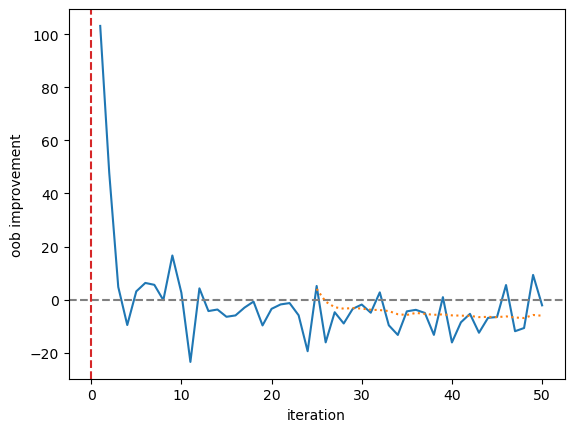

In [42]:
improvement = pd.Series(
    est_early_stopping.oob_improvement_,
    index=np.arange(1, 1 + len(est_early_stopping.oob_improvement_))
)
ax = improvement.plot(xlabel="iteration", ylabel="oob improvement")
ax.axhline(0.0, linestyle="--", color="gray")
cutoff = len(improvement) - monitor.max_iter_without_improvement
ax.axvline(cutoff, linestyle="--", color="C3")

_ = improvement.rolling(monitor.window_size).mean().plot(ax=ax, linestyle=":")

In [189]:
#https://scikit-survival.readthedocs.io/en/stable/user_guide/random-survival-forest.html